In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from pathlib import Path

In [3]:
zip_dir = Path('./eia_epm_zips/')
assert zip_dir.exists()

In [11]:
from eia_epm import *

In [27]:
%%time
dfs = Extractor(zip_dir).extract()

CPU times: user 45.7 s, sys: 139 ms, total: 45.8 s
Wall time: 45.8 s


In [28]:
[key.split('_')[0] for key in dfs.keys()]

['coal', 'oil', 'petcoke', 'gas', 'coal', 'oil', 'petcoke', 'gas']

In [29]:
transformed = add_fuel_cols_and_combine(dfs)

In [35]:
m = transformed['monthly']
y = transformed['ytd']

In [73]:
m.index.get_level_values('date').year.value_counts(sort=False)

2006     732
2007    2931
2008    2929
2009    2928
2010    2928
2011    2988
2012    2992
2013    2976
2014    2976
2015    2976
2016    2976
2017    2976
2018    2976
2019    2976
2020    2976
2021    2976
Name: date, dtype: int64

In [74]:
y.index.get_level_values('date').year.value_counts(sort=False)

2006     732
2007    2928
2008    2928
2009    2928
2010    2928
2011    2988
2012    2992
2013    2976
2014    2976
2015    2976
2016    2976
2017    2976
2018    2976
2019    2976
2020    2976
2021    2976
Name: date, dtype: int64

In [36]:
idx = pd.IndexSlice

In [41]:
m.loc[idx[:,'2012'],:].index.get_level_values('date').month.value_counts(sort=False)

1     252
2     252
3     252
4     252
5     248
6     248
7     248
8     248
9     248
10    248
11    248
12    248
Name: date, dtype: int64

In [42]:
m.loc[idx[:,'2013'],:].index.get_level_values('date').month.value_counts(sort=False)

1     248
2     248
3     248
4     248
5     248
6     248
7     248
8     248
9     248
10    248
11    248
12    248
Name: date, dtype: int64

In [46]:
m.loc[idx[:,'2012-04'],:].groupby(level='fuel').size()

fuel
coal       63
gas        63
oil        63
petcoke    63
dtype: int64

In [49]:
m.loc[idx[:,'2012-05'],:].groupby(level='fuel').size()

fuel
coal       62
gas        62
oil        62
petcoke    62
dtype: int64

In [50]:
m.loc[idx[:,'2012-05'],:].groupby(level='region').size().eq(4).all()

True

In [66]:
# Census category change between 2011-04 and 2011-05 (revised data)
# "Pacfic" splits into "Pacific Contiguous" and "Pacific Noncontiguous"
# This split takes a year to drop out of the index because of the revision lag
set(m.loc[idx[:,'2011-04'],:].index.get_level_values('region').unique()).symmetric_difference(
    set(m.loc[idx[:,'2012-05'],:].index.get_level_values('region').unique()))

{'Pacific', 'Pacific Contiguous', 'Pacific Noncontiguous'}

In [72]:
# confirm same for ytd data
set(y.loc[idx[:,'2011-04'],:].index.get_level_values('region').unique()).symmetric_difference(
    set(y.loc[idx[:,'2012-05'],:].index.get_level_values('region').unique()))

{'Pacific', 'Pacific Contiguous', 'Pacific Noncontiguous'}

In [64]:
m.loc[idx['Pacific Contiguous','2011-05'],:]

Electric Power Sector        Electric Utilities         \
is_revised                 False   True              False   True   
fuel                                                                
coal                         NaN      W                NaN     --   
gas                          NaN   4.89                NaN    5.3   
oil                          NaN  26.06                NaN  26.09   
petcoke                      NaN   2.88                NaN     --   

           Independent Power Producers       yoy_pct_change       
is_revised                       False  True          False True  
fuel                                                              
coal                               NaN     W            NaN  NaN  
gas                                NaN  4.69            NaN  NaN  
oil                                NaN    NM            NaN  NaN  
petcoke                            NaN  2.88            NaN  NaN

<AxesSubplot:xlabel='date'>

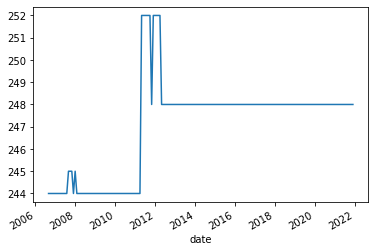

In [68]:
m.groupby('date').size().plot()

<AxesSubplot:xlabel='date'>

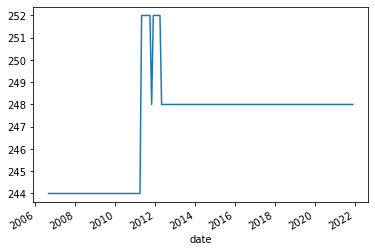

In [75]:
y.groupby('date').size().plot()

In [71]:
# not sure why this month is missing but also don't care -- before our period of interest
m.groupby('date').size().asfreq('MS')[m.groupby('date').size().asfreq('MS').isna()]

date
2006-12-01   NaN
Freq: MS, dtype: float64

In [76]:
# same for ytd
y.groupby('date').size().asfreq('MS')[y.groupby('date').size().asfreq('MS').isna()]

date
2006-12-01   NaN
Freq: MS, dtype: float64

# coherence check: % change

In [78]:
m.head(2)

Electric Power Sector       Electric Utilities        \
is_revised                              False  True              False  True   
region  date       fuel                                                        
Alabama 2006-09-01 coal                   NaN  2.11                NaN  2.11   
                   gas                    NaN  6.36                NaN  7.15   

                        Independent Power Producers       yoy_pct_change       
is_revised                                    False  True          False True  
region  date       fuel                                                        
Alabama 2006-09-01 coal                         NaN    --            NaN  NaN  
                   gas                          NaN  5.54            NaN  NaN

In [94]:
contemporary = pd.to_numeric(m.loc[:, idx['Electric Power Sector', False]], errors='coerce')
revised = pd.to_numeric(m.loc[:, idx['Electric Power Sector', True]], errors='coerce')

In [103]:
m[('contemp', False)] = contemporary
m[('revised', True)] = revised

In [156]:
test = next(iter(m.groupby(level=['region', 'fuel'], as_index=False)[[('contemp', False), ('revised', True)]]))[1]

In [157]:
test

contemp revised
is_revised                False    True
region  date       fuel                
Alabama 2006-09-01 coal     NaN    2.11
        2006-10-01 coal     NaN    2.35
        2006-11-01 coal     NaN    2.14
        2007-01-01 coal     NaN    2.05
        2007-02-01 coal     NaN    2.02
...                         ...     ...
        2021-08-01 coal    2.09     NaN
        2021-09-01 coal    2.05     NaN
        2021-10-01 coal    2.13     NaN
        2021-11-01 coal    2.18     NaN
        2021-12-01 coal    2.33     NaN

[183 rows x 2 columns]

In [155]:
df_dt = test.reset_index(level=['region', 'fuel'], drop=False)
df_dt

,region,fuel,contemp,revised
is_revised,,,False,True
date,,,,
2006-09-01,Alabama,coal,NaN,2.11
2006-10-01,Alabama,coal,NaN,2.35
2006-11-01,Alabama,coal,NaN,2.14
2007-01-01,Alabama,coal,NaN,2.05
2007-02-01,Alabama,coal,NaN,2.02
...,...,...,...,...
2021-08-01,Alabama,coal,2.09,NaN
2021-09-01,Alabama,coal,2.05,NaN


In [158]:
df_dt[('asdf', '')] = lagged

In [159]:
df_dt

,region,fuel,contemp,revised,asdf
is_revised,,,False,True,
date,,,,,
2006-09-01,Alabama,coal,NaN,2.11,NaN
2006-10-01,Alabama,coal,NaN,2.35,NaN
2006-11-01,Alabama,coal,NaN,2.14,NaN
2007-01-01,Alabama,coal,NaN,2.05,NaN
2007-02-01,Alabama,coal,NaN,2.02,NaN
...,...,...,...,...,...
2021-08-01,Alabama,coal,2.09,NaN,2.23
2021-09-01,Alabama,coal,2.05,NaN,2.25


In [154]:
lagged = df_dt.loc[:, ('revised', True)].shift(periods=12, freq='MS')
lagged

date
2007-09-01    2.11
2007-10-01    2.35
2007-11-01    2.14
2008-01-01    2.05
2008-02-01    2.02
              ... 
2022-08-01     NaN
2022-09-01     NaN
2022-10-01     NaN
2022-11-01     NaN
2022-12-01     NaN
Name: (revised, True), Length: 183, dtype: float64

In [180]:
def epm_yoy_change(df):
    df_dt = df.reset_index(level=['region', 'fuel'], drop=False)
    df_dt[('lagged_revised', False)] = df_dt.loc[:, ('revised', True)].shift(periods=12, freq='MS')
    df_dt[('calc_pct_yoy', False)] = df_dt.loc[:,('contemp', False)].sub(df_dt.loc[:, ('lagged_revised', False)]).div(df_dt.loc[:,('contemp', False)]).mul(100)
    new_idx = pd.MultiIndex.from_frame(df_dt.loc[:, [('region', ''), ('fuel', '')]].reset_index(), names = ['date', 'region', 'fuel'])
    out = df_dt.loc[:, ('calc_pct_yoy', False)]
    out.index = new_idx
    return out.rename('calc_pct_yoy')

<AxesSubplot:xlabel='date,region,fuel'>

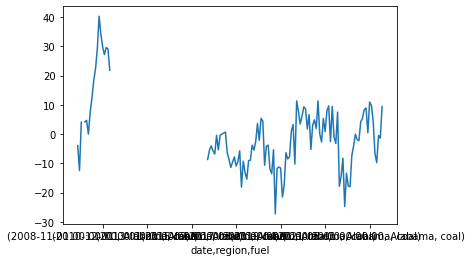

In [181]:
epm_yoy_change(test).plot()

In [182]:
epm_yoy_change(test)

date        region   fuel
2006-09-01  Alabama  coal         NaN
2006-10-01  Alabama  coal         NaN
2006-11-01  Alabama  coal         NaN
2007-01-01  Alabama  coal         NaN
2007-02-01  Alabama  coal         NaN
                               ...   
2021-08-01  Alabama  coal   -6.698565
2021-09-01  Alabama  coal   -9.756098
2021-10-01  Alabama  coal   -0.469484
2021-11-01  Alabama  coal   -1.376147
2021-12-01  Alabama  coal    9.442060
Name: (calc_pct_yoy, False), Length: 183, dtype: float64

<AxesSubplot:xlabel='region,date,fuel'>

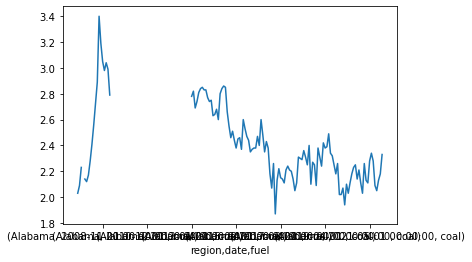

In [132]:
test.iloc[:, 0].plot()

In [183]:
m.groupby(level=['region', 'fuel'], as_index=False)[[('contemp', False), ('revised', True)]].apply(epm_yoy_change)

TypeError: Series.name must be a hashable type

In [188]:
lagged = m.groupby(level=['region', 'fuel'], as_index=False).shift(12)[('revised', True)]
m[('calc_pct_yoy', False)] = m.loc[:, ('contemp', False)].sub(lagged).div(lagged) * 100

In [190]:
m[('yoy_diff', False)] = pd.to_numeric(m.loc[:, ('yoy_pct_change', False)], errors='coerce').sub(m.loc[:, ('calc_pct_yoy', False)])

<AxesSubplot:xlabel='region,date,fuel'>

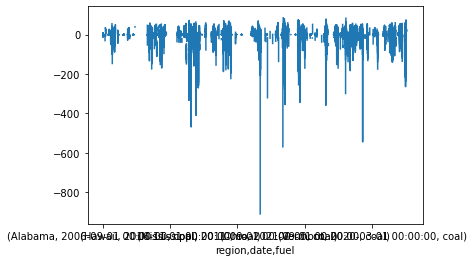

In [191]:
m[('yoy_diff', False)].plot()

In [195]:
m[('yoy_diff', False)].isna().mean()

0.6461780058391577

In [194]:
pd.to_numeric(['W'], errors='coerce')

array([nan])

<AxesSubplot:>

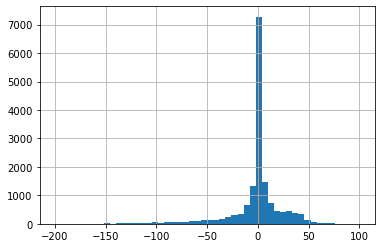

In [198]:
m[('yoy_diff', False)].hist(bins=50, range=(-200,100))

In [199]:
m

Electric Power Sector        Electric Utilities  \
is_revised                                 False   True              False   
region  date       fuel                                                      
Alabama 2006-09-01 coal                      NaN   2.11                NaN   
                   gas                       NaN   6.36                NaN   
                   oil                       NaN  13.62                NaN   
                   petcoke                   NaN     --                NaN   
        2006-10-01 coal                      NaN   2.35                NaN   
...                                          ...    ...                ...   
Wyoming 2021-11-01 petcoke                    --    NaN                 --   
        2021-12-01 coal                        W    NaN               1.55   
                   gas                         W    NaN               8.55   
                   oil                     21.25    NaN              21.25   
                   petcoke                    --    NaN                 --   

                                  Independent Power Producers        \
is_revised                   True                       False  True   
region  date       fuel                                               
Alabama 2006-09-01 coal      2.11                         NaN    --   
                   gas       7.15                         NaN  5.54   
                   oil      13.62                         NaN    --   
                   petcoke     --                         NaN    --   
        2006-10-01 coal      2.35                         NaN    --   
...                           ...                         ...   ...   
Wyoming 2021-11-01 petcoke    NaN                          --   NaN   
        2021-12-01 coal       NaN                           W   NaN   
                   gas        NaN                           W   NaN   
                   oil        NaN                          --   NaN   
                   petcoke    NaN                          --   NaN   

                           yoy_pct_change      contemp revised calc_pct_yoy  \
is_revised                          False True   False    True        False   
region  date       fuel                                                       
Alabama 2006-09-01 coal               NaN  NaN     NaN    2.11          NaN   
                   gas                NaN  NaN     NaN    6.36          NaN   
                   oil                NaN  NaN     NaN   13.62          NaN   
                   petcoke            NaN  NaN     NaN     NaN          NaN   
        2006-10-01 coal               NaN  NaN     NaN    2.35          NaN   
...                                   ...  ...     ...     ...          ...   
Wyoming 2021-11-01 petcoke             --  NaN     NaN     NaN          NaN   
        2021-12-01 coal                 W  NaN     NaN     NaN          NaN   
                   gas                  W  NaN     NaN     NaN          NaN   
                   oil               0.74  NaN   21.25     NaN    74.037674   
                   petcoke             --  NaN     NaN     NaN          NaN   

                             yoy_diff  
is_revised                      False  
region  date       fuel                
Alabama 2006-09-01 coal           NaN  
                   gas            NaN  
                   oil            NaN  
                   petcoke        NaN  
        2006-10-01 coal           NaN  
...                               ...  
Wyoming 2021-11-01 petcoke        NaN  
        2021-12-01 coal           NaN  
                   gas            NaN  
                   oil     -73.297674  
                   petcoke        NaN  

[45212 rows x 12 columns]